In [20]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report
from tensorflow.keras import models
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from keras import backend as K

In [21]:
df_ready = pd.read_csv('df_ready.csv')

In [22]:
X = df_ready.drop(['year','month','day','is_canceled'], axis=1).to_numpy()
y = df_ready['is_canceled'].to_numpy()
scaler = preprocessing.StandardScaler()
X_standardized = scaler.fit_transform(X)

print("Mean Before Standardized:", round(X[:,0].mean()))
print("Standard deviation Before Standardized:", X[:,0].std())
print("\nMean After Standardized:", round(X_standardized[:,0].mean()))
print("Standard deviation After Standardized:", X_standardized[:,0].std())

Mean Before Standardized: 104.0
Standard deviation Before Standardized: 106.86264950916215

Mean After Standardized: 0.0
Standard deviation After Standardized: 1.0


In [23]:
#Build Model
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def create_model():
    network = models.Sequential()
    network.add(Dense(units=128, activation="elu", input_shape=(X.shape[1],)))
    network.add(Dense(units=64, activation="elu", kernel_regularizer = l2(0.3), bias_regularizer = l2(0.3)))
    network.add(Dense(units=32, activation="elu", kernel_regularizer = l2(0.3), bias_regularizer = l2(0.3)))
    network.add(Dense(units=1, activation="sigmoid"))
    
    opt = Adam(lr=0.001, decay = 1e-5, beta_1=0.9, beta_2=0.999, amsgrad=False)
    network.compile(loss="binary_crossentropy",
                    optimizer=opt, 
                    metrics=["accuracy", f1_m])
    return network

network = create_model()


Train on 76409 samples, validate on 19103 samples
Epoch 1/20
76409/76409 [==============================] - 10s 137us/sample - loss: 4.2670 - accuracy: 0.8185 - f1_m: 0.7266 - val_loss: 0.4552 - val_accuracy: 0.8191 - val_f1_m: 0.7396
Epoch 2/20
76409/76409 [==============================] - 6s 72us/sample - loss: 0.4271 - accuracy: 0.8253 - f1_m: 0.7389 - val_loss: 0.4192 - val_accuracy: 0.8205 - val_f1_m: 0.7364
Epoch 3/20
76409/76409 [==============================] - 6s 81us/sample - loss: 0.4050 - accuracy: 0.8264 - f1_m: 0.7410 - val_loss: 0.4074 - val_accuracy: 0.8223 - val_f1_m: 0.7381
Epoch 4/20
76409/76409 [==============================] - 6s 82us/sample - loss: 0.3932 - accuracy: 0.8279 - f1_m: 0.7435 - val_loss: 0.4016 - val_accuracy: 0.8203 - val_f1_m: 0.7335
Epoch 5/20
76409/76409 [==============================] - 6s 83us/sample - loss: 0.3842 - accuracy: 0.8305 - f1_m: 0.7480 - val_loss: 0.3872 - val_accuracy: 0.8293 - val_f1_m: 0.7565
Epoch 6/20
76409/76409 [=========

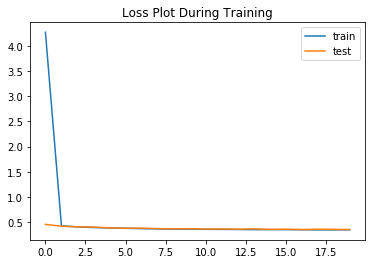

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle = True, test_size = 0.2)
scaler = preprocessing.StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
history = network.fit(x = X_train, y = y_train, epochs = 20, batch_size = 128, validation_split = 0.2, shuffle = True)

#Plot Loss
plt.title('Loss Plot During Training')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [25]:
y_pred = network.predict(X_test).ravel().round()
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.92      0.88     15054
           1       0.84      0.73      0.78      8824

    accuracy                           0.85     23878
   macro avg       0.84      0.82      0.83     23878
weighted avg       0.85      0.85      0.84     23878

